<a href="https://colab.research.google.com/github/jonasbarth/nnds-2023-final-project/blob/main/NNDS_2023_Final_Homework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural Networks for Data Science Applications
## End-of-term homework: Advanced transfer learning

**Name**: *Jonas Barth*

**Matricola**: *2050678*

> ✍ Upload the completed notebook **at least two days** before your expected exam's date on the Google Classroom page. For example, for the **January 12th** session, you should upload it by **January 9th, 23:59 Rome time**.

In [2]:
import datetime

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [3]:
# To ensure reproducible results (as much as possible)
tf.keras.utils.set_random_seed(1234)

### Instructions

1. The homework is divided into two exercises. The first one (**10 points**) is mandatory for everyone. The second one (**5 points**) is mandatory only if you have not submitted the first homework or if you want to increase the mark.
2. If you score well on the project but poorly on the oral, the grade can be kept for the entire academic year (up to October 2024).

**IMPORTANT - read carefully before starting**:

> 🟨 *External material*: if you use any external material or inspiration for the code, reference it *explicitly* in the corresponding cell. For the textual descriptions, copy-paste *is not allowed*. <ins>Not following these two points is an immediate 0 mark</ins>.

> 🔵 *Grammar*: for the textual descriptions, I will remove points for too many grammatical or textual errors. Please try to be precise and provide nice-to-read descriptions, like if you were writing a report.

> 🟥 *Vectorization and TensorFlow*: the homework must be done _fully in TensorFlow_ and vectorizing the code as much as possible (e.g., do not loop explicitly over the batch dimension).

> 🟪 *Math*: you can also use LaTeX in Markdown if you need to write equations or if you need generic math notation.

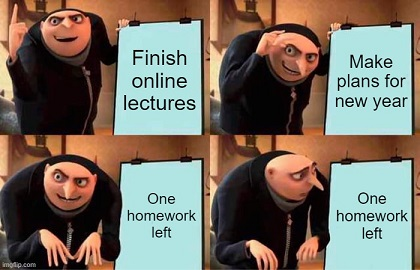

## Warmup: Data loading

**For this part, select an interesting dataset.**

*   This is similar to [Exercise 1 from the mid-term homework](https://colab.research.google.com/drive/1oDbshJeY62Id1O5pbsCrNFX9PdSY1ITP?usp=sharing), which you can check for completeness.
*   You should use a **different dataset** from the first homework, possibly of higher complexity.
*   Any data type (tabular, images, videos, audio, time-series, graphs, ...) is okay.

## Project Goal
The idea of the project is to first fine-tune a VGG16 on a binary satellite image classification on images that either contain ships or not using classic gradient based optimisation of the final prediction layers, and then use Low Rank Adaptation (LoRa) to transfer the learned features onto a second binary satellite image classification of images that contain planes or not.

The reason for first fine-tuning the VGG16 on the airplane dataset is due to the fact that the base VGG16 has 1000 classes but my target ship and airplane dataset only 2. Since LoRa aims to learn a low rank approximation of the weights, and due to the limited data it is only feasible to retrain the final VGG16 layers, the weight matrix that I approximate should not change shape between the original model and transfer model.

The idea of this finetuning task is that planes and ships viewed from above have a similar elongated shape and that the features can be therefore be reused.

## Datasets

### Airplanes
The airplanes dataset taken from [Kaggle](https://www.kaggle.com/datasets/rhammell/planesnet) is a binary classification of satellite images collected over multiple airports in California. It includes _32,000_ _20x20_ RGB images labeled with either a "plane" (class 1) or "no-plane" (class 0) classification. Since the plane images are _80x80_ and we want to maintain the same sized network architecture for both datasets, I will later resize the plane images to _80x80_. 

No Plane Patch             |  Plane Patch
:-------------------------:|:-------------------------:
<img src="https://github.com/jonasbarth/nnds-2023-final-project/blob/main/data/planes/example_patches/example_patch_no_plane.png?raw=1" width="200">|<img src="https://github.com/jonasbarth/nnds-2023-final-project/blob/main/data/planes/example_patches/example_patch_plane.png?raw=1" width="200">
24000 samples | 8000 samples
 

### Ships
The ship dataset contains a binary ship classification of satellite images from the San Francisco and San Pedro Bay, taken from [Kaggle](https://www.kaggle.com/datasets/rhammell/ships-in-satellite-imagery). The dataset contains _4,000_ RGB sub patches of size _80x80_ with a 3 meter pixel resolution, taken from 8 satellite images. Each patch either contains a ship (class 1) or not (class 0). Out of _4,000_ images, _1,000_ belong to class 1 (ship) and _3,000_ belong to class 0 (no ship).

No Ship Patch             |  Ship Patch
:-------------------------:|:-------------------------:
<img src="https://github.com/jonasbarth/nnds-2023-final-project/blob/main/data/ships/example_patches/example_patch_no_ship.png?raw=1" width="200">|<img src="https://github.com/jonasbarth/nnds-2023-final-project/blob/main/data/ships/example_patches/example_patch_ship.png?raw=1" width="200">
3000 samples | 1000 samples

Hence, the goal is to train a model to distinguish between these two classes.

### Metadata Creation
Each image file name in both datasets contains information about the class, scene ID, longitude and latitude in the following format:
```
<label>_<scene id>_<longitude>_<latitude>.png
```

To ease the data loading for the model later, I will parse this information into a pandas dataframe with two columns:

label | file_name
:----:|:----:
1 | 0__20150718_184300_090b__-122.35324421973536_37.772113980272394.png
. | .
. | .
. | .
. | .

That way, each file can easily be associated with its label. To do this, I will iterate over the image file names in the `data/shipsnet` directory, extract the label and store it as list inside a list. Each sublist will be a row in the dataframe later.

### Download Data
I have provided my own zip files on an AWS Bucket that contain both datasets.

In [4]:
import os
import requests
import zipfile

def download_and_unzip(url: str, zip_file_path: str, extract_folder_path: str):
    """Downloads and extracts the zip data for the project.

    Args:
        url (str): the url from which to GET the zip.
        zip_file_path (str): path where to save the zip file.
        extract_folder_path (str): folder where to extract the zip.
    """
    # Download the zip file
    response = requests.get(url)

    # Check if the request was successful (status code 200)
    if response.status_code == 200:
        # Save the downloaded zip file
        with open(zip_file_path, "wb") as f:
            f.write(response.content)

        # Extract the contents of the zip file into the data folder
        with zipfile.ZipFile(zip_file_path, "r") as zip_ref:
            zip_ref.extractall(extract_folder_path)

        print("Zip file downloaded and extracted successfully.")
    else:
        print("Failed to download the zip file.")

Let's download both datasets from the AWS bucket into the `data/` directory.

In [81]:
planes_url = "https://nnds-2023.s3.eu-north-1.amazonaws.com/planes.zip"
ships_url = "https://nnds-2023.s3.eu-north-1.amazonaws.com/ships.zip"

planes_zip_path = "planes.zip"
ships_zip_path = "ships.zip"

# Define the path where you want to extract the contents of the zip file
extracted_folder_path = "data"

# Create the data folder if it doesn't exist
os.makedirs(extracted_folder_path, exist_ok=True)

download_and_unzip(ships_url, ships_zip_path, extracted_folder_path)
download_and_unzip(planes_url, planes_zip_path, extracted_folder_path)

Zip file downloaded and extracted successfully.
Zip file downloaded and extracted successfully.


In [4]:
import os
import pandas as pd

def get_dataset_metadata(images_path: str):
    """Gets filenames and labels of the data found at the given path.

    Args:
        images_path (str): the directory where the image files are stored.

    Returns:
        pd.DataFrame: a pandas dataframe with columns ["label", "file_name"].
    """
    meta_data = []

    # list all the image files
    for image_file in os.listdir(images_path):

        # the class label is always the first character of the file name
        label = image_file[0]
        meta_data.append([int(label), os.path.join(images_path, image_file)])

    meta_data = pd.DataFrame(meta_data, columns=["label", "file_name"])
    return meta_data

Create the metadata pandas dataframes.

In [5]:
planes_metadata = get_dataset_metadata("data/planes/planesnet")
ships_metadata = get_dataset_metadata("data/ships/shipsnet")

image_size = (80, 80)

I want to be able to utilise the **TensorFlow dataset utility**, which let's you create an image dataset by providing a folder name. For this, I need to split the image data into **train** and **test** first.

In [6]:
from pathlib import Path
import shutil

def create_train_test(data: pd.DataFrame, train_size: float):
    """Creates train and test splits for the given image data.

    The function creates a train and test directory one directory above the images.

    Args:
        data (pd.DataFrame): the dataframe with the image data information. Should contain columns: label, file_name.
        train_size (float): the percentage of training examples.

    Returns:
        X_train (list): the list of images in the training dataset.
        X_test (list): the list of images in the test dataset.
        y_train (list): the labels of the training dataset, matches the order of X_train.
        y_test (list): the labels of the test dataset, matches the order of X_test.
    """
    from sklearn.model_selection import train_test_split

    X_train, X_test, y_train, y_test = train_test_split(data.file_name, data.label, train_size=train_size)

    # create the train and test paths
    images_dir = os.path.split(X_train.iloc[0])[0]
    images_parent_dir = os.path.split(images_dir)[0]
    train_path = os.path.join(images_parent_dir, "train")
    test_path = os.path.join(images_parent_dir, "test")

    train_path = Path(train_path)
    test_path = Path(test_path)

    # if the train/test directories already exist, we want to delete them
    if train_path.exists():
        shutil.rmtree(train_path)

    if test_path.exists():
        shutil.rmtree(test_path)

    # create the train and test directories
    train_path.mkdir(exist_ok=False, parents=True)
    test_path.mkdir(exist_ok=False, parents=True)

    train_paths = list(map(lambda image: os.path.join(train_path, image), map(lambda image_path: os.path.split(image_path)[-1], X_train)))
    # replace all dots except for the extension because Tensorflow thinks the first . in the filename marks the extension.
    train_paths = list(map(lambda image_path: replace_dots(image_path, "#"), train_paths))

    test_paths = list(map(lambda image: os.path.join(test_path, image), map(lambda image_path: os.path.split(image_path)[-1], X_test)))
    test_paths = list(map(lambda image_path: replace_dots(image_path, "#"), test_paths))

    # copy over the files
    for original_path, dest_path in zip(X_train, train_paths):
        shutil.copy(original_path, dest_path)

    for original_path, dest_path in zip(X_test, test_paths):
        shutil.copy(original_path, dest_path)

    return X_train, X_test, y_train.to_list(), y_test.to_list()


def replace_dots(path: str, replacement: str):
    """Replace the . with a replacement string, without breaking the extension.

    Args:
        path (str): the path string of which we take the file and replace . with the replacement.
        replacement (str): the character with which to replace the .

    Returns:
        (str) the full path with the . replaced but extension kept intact.
    """
    path, file = os.path.split(path)
    ext = os.path.splitext(file)[-1]
    file = file.replace(".", replacement)
    file = file.replace(f"{replacement}{ext[1:]}", f"{ext}")
    return os.path.join(path, file)

Let's finally load the train and test sets for the ships and planes dataset, using an `80/20` split.

In [7]:
X_train_ships, X_test_ships, y_train_ships, y_test_ships = create_train_test(ships_metadata, 0.8)
X_train_planes, X_test_planes, y_train_planes, y_test_planes = create_train_test(planes_metadata, 0.8)

### Exercise 1: Advanced transfer learning (10 points)

For this exercise, you are asked to implement some form of "advanced" transfer learning method. These include, but are not limited to, the content of Lecture 10 in the course, e.g.:

1.   **Parameter-efficient fine-tuning** (PEFT) methods (LoRA, adapters, soft prompting, ...).
2.   **Task vectors** and arithmetic in the weight space.
3.   **Model merging** and model combination (e.g., relative representations).

The following are useful surveys and papers you can take inspiration from. If you are in doubt, ask me before starting.

1. [Scaling Down to Scale Up: A Guide to Parameter-Efficient Fine-Tuning](https://arxiv.org/abs/2303.15647) - A survey on PEFT models.
2. [Modular Deep Learning](https://arxiv.org/abs/2302.11529) - A tutorial on the emerging paradigm of modular deep learning, in which networks are composed of modular building blocks. This is connected to PEFT, see in particular Section 7.
3. Examples of model merging: [model ratatouille](https://arxiv.org/abs/2212.10445), [git re-basin](https://arxiv.org/abs/2209.04836), [Fisher averaging](https://arxiv.org/abs/2111.09832).
4. Examples of task arithmetic: [simple arithmetic](https://arxiv.org/abs/2212.04089), [tangent space](https://arxiv.org/abs/2305.12827).

For this exercise, you can either transfer from two models that you trained autonomously (e.g., train one model on another dataset, add an adapter, fine-tune on the dataset you selected before), or fine-tune directly from a pre-trained model found on the web. For finding pre-trained models, you can check [tf.keras.applications](https://www.tensorflow.org/api_docs/python/tf/keras/applications), [TensorFlow model garden](https://www.tensorflow.org/guide/model_garden?hl=it), or the [Hugging Face Hub](https://huggingface.co/docs/hub/index).

> 🟥 Remember that the homework must be done fully in TensorFlow, with no external libraries (when in doubt, ask).

✍ **DESCRIPTION OF THE CODE**

*Provide a description of what you are implementing, both as text and in the comments of the code.*

**TODO**: add description here (1-2 paragraphs).

## 1. Traditional Finetuning
I will use a **VGG16** for this project. The reason for choosing this now "outdated" architecture over the widely adopted **ResNet** is that the VGG16 has more fully connected layers to which Lora can be applied more easily. Usually when doing transfer learning with a ConvNet, the earlier convolutional layers are frozen since the features that they extract from images are very reusable. Only the deeper fully connected layers are retrained. Here I will do the same and only keep the 3 final fully connected layers.

<img src="https://github.com/jonasbarth/nnds-2023-final-project/blob/main/images/vgg16_architecture.png?raw=1" width="750">

### Ship Images Finetuning (Traditional)
First, I will finetune a VGG16 on the ship dataset using the traditional gradient based method where only the final fully connected layers are retrained.

#### Create TF Datasets
Let's create the two datasets that we will be using with the help of the `keras.utils` package, both with a validation split of $0.2$. First the ships.

In [8]:
batch_size = 32

ship_train, ship_val = tf.keras.utils.image_dataset_from_directory(directory="data/ships/train", labels=y_train_ships, validation_split=0.2, subset="both", seed=0, image_size=image_size, shuffle=True, batch_size=batch_size)
ship_test = tf.keras.utils.image_dataset_from_directory(directory="data/ships/test", labels=y_test_ships, seed=0, image_size=image_size, shuffle=True, batch_size=batch_size)

Found 3200 files belonging to 2 classes.
Using 2560 files for training.
Using 640 files for validation.
Found 800 files belonging to 2 classes.


Then for the planes.

In [9]:
planes_train, planes_val = tf.keras.utils.image_dataset_from_directory(directory="data/planes/train", labels=y_train_planes, validation_split=0.2, subset="both", seed=0, image_size=image_size, shuffle=True, batch_size=batch_size)
planes_test = tf.keras.utils.image_dataset_from_directory(directory="data/planes/test", labels=y_test_planes, seed=0, image_size=image_size, shuffle=True, batch_size=batch_size)

Found 25600 files belonging to 2 classes.
Using 20480 files for training.
Using 5120 files for validation.
Found 6400 files belonging to 2 classes.


### Load Model
Here, we load the pretrained VGG16 model, but **without** the final connected layers, since we want to fine tune those ourselves.

In [10]:
vgg16 = tf.keras.applications.vgg16.VGG16(include_top=False, input_shape=(*image_size, 3))

### Create Prediction Head
Here we create the prediction layers. These are the **same** as the original VGG16 architecture, apart from the final dense layer that now performs **binary classification** instead of **1000-way**. The fully connected layers are followed by a **ReLU** activation function and have L1 and L2 regularisers.

In [19]:
flatten = tf.keras.layers.Flatten()(vgg16.output)
regulariser = tf.keras.regularizers.L1L2(l1=0.001, l2=0.001)
fc1 = tf.keras.layers.Dense(4096, activation="relu", kernel_regularizer=regulariser)(flatten)
fc2 = tf.keras.layers.Dense(4096, activation="relu", kernel_regularizer=regulariser)(fc1)

# add the new prediction head for binary classification
pred = tf.keras.layers.Dense(1, kernel_regularizer=regulariser)(fc2)

In [20]:
custom_vgg16 = tf.keras.models.Model(inputs=vgg16.input, outputs=pred)

Since we only want to train the final fully connected layers, freeze all previous layers by setting the `trainable` attribute to `False`.

In [21]:
custom_vgg16.trainable = True
for layer in custom_vgg16.layers[:-4]:
    layer.trainable = False

## Create Preprocessing Layers
We want our images to be standardised with zero mean and standard deviation of one. Hence, we will inject a preprocessing layer into the model that does this for us.

In [22]:
# Add the rescaling layer as the first layer of the model
inputs = tf.keras.Input(shape=(*image_size, 3))
x = tf.keras.layers.Rescaling(scale=1./255)(inputs)
outputs = custom_vgg16(x)

# Create the final model
final_model = tf.keras.models.Model(inputs=inputs, outputs=outputs)

We also want to make use of the **Tensorflow Callbacks** for:

* early stopping if the loss delta falls below a certain threshold
* saving the model every $n$ epochs
* writing to tensorboard

In [23]:
import datetime

# Include the epoch in the file name (uses `str.format`)
ships_checkpoint_path = "checkpoints/ships-vgg16-cp-{epoch:04d}.ckpt"
ships_checkpoint_dir = os.path.dirname(ships_checkpoint_path)
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
Path(ships_checkpoint_dir).mkdir(exist_ok=True, parents=True)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3, min_delta=0.005)
model_checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(ships_checkpoint_path, save_freq='epoch', period=5)
tensorboard_cb = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

Compile our custom VGG16 model with the binary prediction head, tracking the accuracy of the predictions.

In [24]:
custom_vgg16.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5, weight_decay=0.01),
                    metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0, name='accuracy')])

And fit it with the **ship data**.

In [25]:
custom_vgg16_history = custom_vgg16.fit(ship_train, epochs=50, validation_data=ship_val, batch_size=batch_size, callbacks=[early_stopping_cb, model_checkpoint_cb, tensorboard_cb], verbose=1)

Epoch 1/50
80/80 [==============================] - 37s 455ms/step - loss: 362.1794 - accuracy: 0.6848 - val_loss: 358.5453 - val_accuracy: 0.6062
Epoch 2/50
80/80 [==============================] - 37s 458ms/step - loss: 354.3937 - accuracy: 0.7887 - val_loss: 351.1596 - val_accuracy: 0.6016
Epoch 3/50
80/80 [==============================] - 36s 445ms/step - loss: 346.6039 - accuracy: 0.8605 - val_loss: 343.3143 - val_accuracy: 0.6141
Epoch 4/50
80/80 [==============================] - 33s 416ms/step - loss: 338.4789 - accuracy: 0.9043 - val_loss: 335.0483 - val_accuracy: 0.6469
Epoch 5/50
80/80 [==============================] - ETA: 0s - loss: 330.0258 - accuracy: 0.9270INFO:tensorflow:Assets written to: checkpoints/ships-vgg16-cp-0005.ckpt/assets


INFO:tensorflow:Assets written to: checkpoints/ships-vgg16-cp-0005.ckpt/assets


80/80 [==============================] - 36s 457ms/step - loss: 330.0258 - accuracy: 0.9270 - val_loss: 326.4899 - val_accuracy: 0.6531
Epoch 6/50
80/80 [==============================] - 34s 424ms/step - loss: 321.2831 - accuracy: 0.9449 - val_loss: 317.7068 - val_accuracy: 0.6781
Epoch 7/50
80/80 [==============================] - 33s 415ms/step - loss: 312.3276 - accuracy: 0.9559 - val_loss: 308.6491 - val_accuracy: 0.6547
Epoch 8/50
80/80 [==============================] - 33s 416ms/step - loss: 303.2054 - accuracy: 0.9574 - val_loss: 299.5503 - val_accuracy: 0.6859
Epoch 9/50
80/80 [==============================] - 33s 416ms/step - loss: 293.9559 - accuracy: 0.9645 - val_loss: 290.1458 - val_accuracy: 0.6391
Epoch 10/50
80/80 [==============================] - ETA: 0s - loss: 284.6135 - accuracy: 0.9723INFO:tensorflow:Assets written to: checkpoints/ships-vgg16-cp-0010.ckpt/assets


INFO:tensorflow:Assets written to: checkpoints/ships-vgg16-cp-0010.ckpt/assets


80/80 [==============================] - 34s 431ms/step - loss: 284.6135 - accuracy: 0.9723 - val_loss: 280.8111 - val_accuracy: 0.6531
Epoch 11/50
80/80 [==============================] - 33s 418ms/step - loss: 275.2191 - accuracy: 0.9715 - val_loss: 271.3784 - val_accuracy: 0.6594
Epoch 12/50
80/80 [==============================] - 35s 436ms/step - loss: 265.7997 - accuracy: 0.9727 - val_loss: 261.9876 - val_accuracy: 0.6656
Epoch 13/50
80/80 [==============================] - 35s 441ms/step - loss: 256.3790 - accuracy: 0.9734 - val_loss: 252.5810 - val_accuracy: 0.6609
Epoch 14/50
80/80 [==============================] - 36s 447ms/step - loss: 246.9835 - accuracy: 0.9773 - val_loss: 243.2258 - val_accuracy: 0.6578
Epoch 15/50
80/80 [==============================] - ETA: 0s - loss: 237.6318 - accuracy: 0.9789INFO:tensorflow:Assets written to: checkpoints/ships-vgg16-cp-0015.ckpt/assets


INFO:tensorflow:Assets written to: checkpoints/ships-vgg16-cp-0015.ckpt/assets


80/80 [==============================] - 36s 449ms/step - loss: 237.6318 - accuracy: 0.9789 - val_loss: 233.8537 - val_accuracy: 0.6469
Epoch 16/50
80/80 [==============================] - 33s 416ms/step - loss: 228.3579 - accuracy: 0.9730 - val_loss: 224.6254 - val_accuracy: 0.6672
Epoch 17/50
80/80 [==============================] - 37s 467ms/step - loss: 219.1687 - accuracy: 0.9777 - val_loss: 215.5256 - val_accuracy: 0.6687
Epoch 18/50
80/80 [==============================] - 37s 463ms/step - loss: 210.0899 - accuracy: 0.9785 - val_loss: 206.4913 - val_accuracy: 0.6609
Epoch 19/50
80/80 [==============================] - 36s 454ms/step - loss: 201.1385 - accuracy: 0.9766 - val_loss: 197.5882 - val_accuracy: 0.6625
Epoch 20/50
80/80 [==============================] - ETA: 0s - loss: 192.3213 - accuracy: 0.9789INFO:tensorflow:Assets written to: checkpoints/ships-vgg16-cp-0020.ckpt/assets


INFO:tensorflow:Assets written to: checkpoints/ships-vgg16-cp-0020.ckpt/assets


80/80 [==============================] - 38s 476ms/step - loss: 192.3213 - accuracy: 0.9789 - val_loss: 188.9625 - val_accuracy: 0.6859
Epoch 21/50
80/80 [==============================] - 37s 469ms/step - loss: 183.6603 - accuracy: 0.9801 - val_loss: 180.3351 - val_accuracy: 0.6828
Epoch 22/50
80/80 [==============================] - 37s 462ms/step - loss: 175.1669 - accuracy: 0.9781 - val_loss: 171.8705 - val_accuracy: 0.6672
Epoch 23/50
80/80 [==============================] - 37s 467ms/step - loss: 166.8535 - accuracy: 0.9797 - val_loss: 163.6613 - val_accuracy: 0.6734
Epoch 24/50
80/80 [==============================] - 36s 454ms/step - loss: 158.7434 - accuracy: 0.9801 - val_loss: 155.6860 - val_accuracy: 0.6687
Epoch 25/50
80/80 [==============================] - ETA: 0s - loss: 150.8413 - accuracy: 0.9777INFO:tensorflow:Assets written to: checkpoints/ships-vgg16-cp-0025.ckpt/assets


INFO:tensorflow:Assets written to: checkpoints/ships-vgg16-cp-0025.ckpt/assets


80/80 [==============================] - 39s 484ms/step - loss: 150.8413 - accuracy: 0.9777 - val_loss: 147.8519 - val_accuracy: 0.6781
Epoch 26/50
80/80 [==============================] - 37s 466ms/step - loss: 143.1681 - accuracy: 0.9785 - val_loss: 140.2971 - val_accuracy: 0.6797
Epoch 27/50
80/80 [==============================] - 38s 475ms/step - loss: 135.7312 - accuracy: 0.9781 - val_loss: 132.9604 - val_accuracy: 0.6594
Epoch 28/50
80/80 [==============================] - 37s 463ms/step - loss: 128.5527 - accuracy: 0.9758 - val_loss: 126.0095 - val_accuracy: 0.6922
Epoch 29/50
80/80 [==============================] - 36s 450ms/step - loss: 121.6587 - accuracy: 0.9754 - val_loss: 119.5395 - val_accuracy: 0.7125
Epoch 30/50
80/80 [==============================] - ETA: 0s - loss: 115.1781 - accuracy: 0.9563INFO:tensorflow:Assets written to: checkpoints/ships-vgg16-cp-0030.ckpt/assets


INFO:tensorflow:Assets written to: checkpoints/ships-vgg16-cp-0030.ckpt/assets


80/80 [==============================] - 39s 484ms/step - loss: 115.1781 - accuracy: 0.9563 - val_loss: 112.8772 - val_accuracy: 0.6438
Epoch 31/50
80/80 [==============================] - 37s 461ms/step - loss: 109.0217 - accuracy: 0.9680 - val_loss: 106.9365 - val_accuracy: 0.6812
Epoch 32/50
80/80 [==============================] - 36s 452ms/step - loss: 103.1798 - accuracy: 0.9766 - val_loss: 101.3061 - val_accuracy: 0.6859
Epoch 33/50
80/80 [==============================] - 37s 459ms/step - loss: 97.6196 - accuracy: 0.9773 - val_loss: 95.8022 - val_accuracy: 0.6797
Epoch 34/50
80/80 [==============================] - 36s 451ms/step - loss: 92.3150 - accuracy: 0.9777 - val_loss: 90.5926 - val_accuracy: 0.6766
Epoch 35/50
80/80 [==============================] - ETA: 0s - loss: 87.2770 - accuracy: 0.9770INFO:tensorflow:Assets written to: checkpoints/ships-vgg16-cp-0035.ckpt/assets


INFO:tensorflow:Assets written to: checkpoints/ships-vgg16-cp-0035.ckpt/assets


80/80 [==============================] - 37s 469ms/step - loss: 87.2770 - accuracy: 0.9770 - val_loss: 85.7135 - val_accuracy: 0.6844
Epoch 36/50
80/80 [==============================] - 36s 456ms/step - loss: 82.5090 - accuracy: 0.9719 - val_loss: 81.2119 - val_accuracy: 0.7047
Epoch 37/50
80/80 [==============================] - 36s 455ms/step - loss: 78.0105 - accuracy: 0.9691 - val_loss: 76.6754 - val_accuracy: 0.6594
Epoch 38/50
80/80 [==============================] - 37s 457ms/step - loss: 73.7696 - accuracy: 0.9742 - val_loss: 72.5822 - val_accuracy: 0.6844
Epoch 39/50
80/80 [==============================] - 37s 463ms/step - loss: 69.7775 - accuracy: 0.9754 - val_loss: 68.6808 - val_accuracy: 0.6719
Epoch 40/50
80/80 [==============================] - ETA: 0s - loss: 66.0474 - accuracy: 0.9680INFO:tensorflow:Assets written to: checkpoints/ships-vgg16-cp-0040.ckpt/assets


INFO:tensorflow:Assets written to: checkpoints/ships-vgg16-cp-0040.ckpt/assets


80/80 [==============================] - 39s 492ms/step - loss: 66.0474 - accuracy: 0.9680 - val_loss: 65.1249 - val_accuracy: 0.6875
Epoch 41/50
80/80 [==============================] - 37s 466ms/step - loss: 62.5455 - accuracy: 0.9672 - val_loss: 61.8185 - val_accuracy: 0.6891
Epoch 42/50
80/80 [==============================] - 36s 450ms/step - loss: 59.2816 - accuracy: 0.9641 - val_loss: 58.6531 - val_accuracy: 0.6969
Epoch 43/50
80/80 [==============================] - 36s 455ms/step - loss: 56.2080 - accuracy: 0.9680 - val_loss: 55.5454 - val_accuracy: 0.6453
Epoch 44/50
80/80 [==============================] - 35s 439ms/step - loss: 53.3880 - accuracy: 0.9559 - val_loss: 52.8518 - val_accuracy: 0.6844
Epoch 45/50
80/80 [==============================] - ETA: 0s - loss: 50.6908 - accuracy: 0.9668INFO:tensorflow:Assets written to: checkpoints/ships-vgg16-cp-0045.ckpt/assets


INFO:tensorflow:Assets written to: checkpoints/ships-vgg16-cp-0045.ckpt/assets


80/80 [==============================] - 38s 475ms/step - loss: 50.6908 - accuracy: 0.9668 - val_loss: 50.2015 - val_accuracy: 0.6516
Epoch 46/50
80/80 [==============================] - 37s 460ms/step - loss: 48.1784 - accuracy: 0.9695 - val_loss: 47.7591 - val_accuracy: 0.6500
Epoch 47/50
80/80 [==============================] - 36s 452ms/step - loss: 45.8534 - accuracy: 0.9508 - val_loss: 45.5315 - val_accuracy: 0.6672
Epoch 48/50
80/80 [==============================] - 36s 456ms/step - loss: 43.6651 - accuracy: 0.9574 - val_loss: 43.3703 - val_accuracy: 0.6703
Epoch 49/50
80/80 [==============================] - 34s 427ms/step - loss: 41.5858 - accuracy: 0.9676 - val_loss: 41.3789 - val_accuracy: 0.6828
Epoch 50/50
80/80 [==============================] - ETA: 0s - loss: 39.6462 - accuracy: 0.9668INFO:tensorflow:Assets written to: checkpoints/ships-vgg16-cp-0050.ckpt/assets


INFO:tensorflow:Assets written to: checkpoints/ships-vgg16-cp-0050.ckpt/assets


80/80 [==============================] - 35s 433ms/step - loss: 39.6462 - accuracy: 0.9668 - val_loss: 39.5217 - val_accuracy: 0.6859


## Evaluation
Let's see how our first finetuned model did, by plotting the train and validation loss and accuracy curves.

In [64]:
train_loss, val_loss = custom_vgg16_history.history["loss"], custom_vgg16_history.history["val_loss"]
train_accuracy, val_accuracy = custom_vgg16_history.history["accuracy"], custom_vgg16_history.history["val_accuracy"]

Looking at the accuracy curves, we see that already after 10 episodes, we have a training accuracy of 90%. The validation does not track the training however, indicating we are overfitting.

In [45]:
def plot_loss_accuracy(loss: np.ndarray, accuracy: np.ndarray, labels: [str]):
    """Plots the training and validation losses and accuracy curves.
    
    Args:
        loss (np.ndarray): the training and validation loss.
        accuracy (np.ndarray): the training and validation accuracy.
        labels (List[str]): the labels of the training and validation sets.
    """
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    
    ax[0].plot(loss, label=labels)
    ax[0].set_title("Loss")
    ax[0].set_xlabel("Epoch")
    ax[0].set_ylabel("BCE")
    ax[0].legend()
    
    ax[1].plot(accuracy, label=labels)
    ax[1].set_title("Accuracy")
    ax[1].set_xlabel("Epoch")
    ax[1].set_ylabel("Accuracy")
    ax[1].legend()
    plt.show()

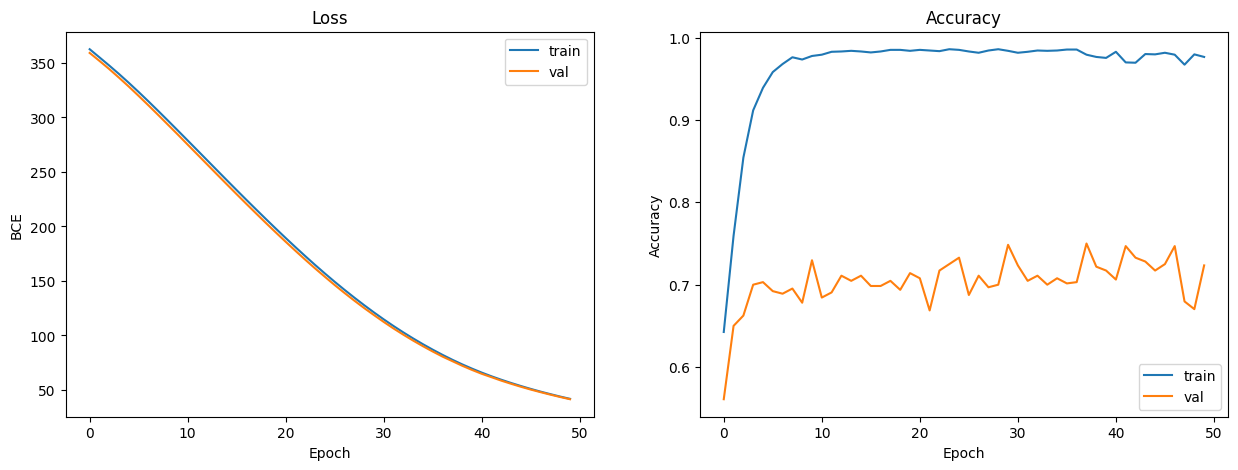

In [66]:
plot_loss_accuracy(np.stack((train_loss, val_loss)).T, np.stack((train_accuracy, val_accuracy)).T, ["train", "val"])

But let's compare how the model does on the ship test set and on the planes test set **before** we apply LoRA. We see that our vgg16 finetuned on the ships, performs already almost similarly on the planes data. After LoRA, we should hopefully pull the accuracy on the planes data to the ship data.

In [98]:
custom_vgg16.evaluate(ship_test), custom_vgg16.evaluate(planes_test)

200/200 [==============================] - 41s 206ms/step - loss: 40.9612 - accuracy: 0.5317


([40.810977935791016, 0.6662499904632568],
 [40.96123123168945, 0.5317187309265137])

In [26]:
def plot_confusion_matrix(y_true, y_pred, class_names):
    
    cm = tf.math.confusion_matrix(y_true, y_pred)
    
    fig, ax = plt.subplots(figsize=(8, 6))
    
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    
    # set the x-y tick marks and class labels
    tick_marks = range(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)
    
    # create text annotations in the tiles
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, cm[i, j].numpy(),
                    ha="center", va="center",
                    color="white" if cm[i, j] > cm.numpy().max() / 2 else "black")
    
    # Set labels and title
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title('Confusion Matrix')
    
    # Adjust layout and display the plot
    plt.tight_layout()
    plt.show()

In [31]:
def plot_confusion_matrix(model, test_dataset, class_names):
    """Plots a confusion matrix for a binary classification."""
    
    # get the predictions (logits) and true labels
    y_pred_logits = []
    y_true = []
    
    for images, labels in test_dataset:
        y_pred_logits.append(model(images))
        y_true.append(labels)
    
    y_pred_logits = tf.concat(y_pred_logits, axis=0)
    y_true = tf.concat(y_true, axis=0)
    y_pred = tf.cast(y_pred_logits > 0, tf.int32)
    
    cm = tf.math.confusion_matrix(y_true, y_pred)
    
    fig, ax = plt.subplots(figsize=(8, 6))
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    
    # set x and y tick marks and class labels
    tick_marks = range(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)
    
    # create text annotations
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, cm[i, j].numpy(),
                    ha="center", va="center",
                    color="white" if cm[i, j] > cm.numpy().max() / 2 else "black")
    
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title('Confusion Matrix')
    
    plt.tight_layout()
    plt.show()

From the confusion matrix we can see that we are very good at predicting **negative samples**, but struggle with **positive samples**.

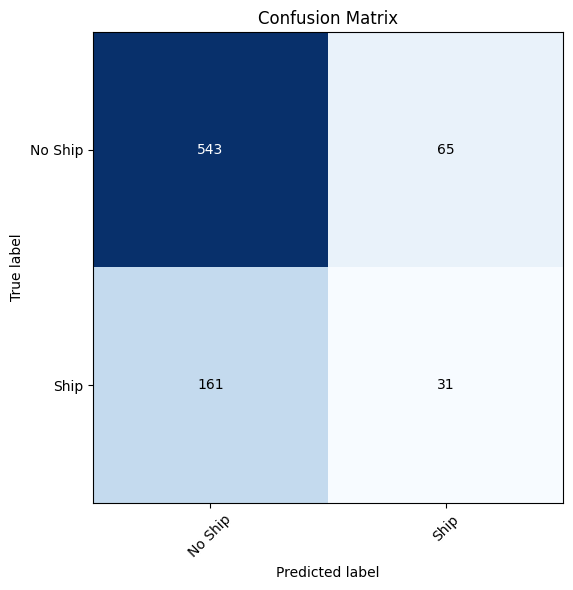

In [32]:
plot_confusion_matrix(custom_vgg16, ship_test, ["No Ship", "Ship"])

## 2. LoRA Finetuning
**Lo**w **R**ank **A**daption is a finetuning method that trains a lower rank representation $BA$ of the original weight matrix $W$. This works because the **rank** of the full weight matrix is usually lower than its **dimensions**, meaning that the information it carries can be encoded with **fewer** dimensions. Thanks to this, we can train much smaller weight matrices and be more efficient when it comes to large models. The VGG16 is not a particularly large model, but it will still be of benefit here because the largest portion of weights are in the **deeper** fully connected layers.

LoRA makes use of 3 weight matrices:

* The already trained weights $W$.
* Matrices $A$ and $B$ that we multiply to make up $W$.

$$
W \in \mathbb{R}^{d \times k} \\
A \in \mathbb{R}^{r \times k} \\
B \in \mathbb{R}^{d \times r} \\
$$

I will apply LoRA to the final fully connected previously finetuned layers of the VGG16. The forward pass $h$ of the model is modified to use the lower rank representation of the matrix, so that we can propagate the loss back through them later. Essentially, the weight delta that would normally be calculated on the **entire matrix** $W$ is instead calculated using the smaller matrices $A$ and $B$.

$$
h = W_0x + \Delta Wx = W_0x + BAx
$$

Initially, we want $\Delta Wx$ to be $0$, hence, we initialise

$$
B = 0 \\
A \sim \mathcal{N}(0, 1)
$$

In [33]:
checkpoint = tf.train.Checkpoint(custom_vgg16)

In [34]:
status = checkpoint.restore("checkpoints/ships-vgg16-cp-0010.ckpt")

To make LoRA possible, we need the **weights** of the fully connected layers as well as their *+shape**.

In [35]:
fc1_weights = custom_vgg16.layers[-3].weights[0]
fc2_weights = custom_vgg16.layers[-2].weights[0]
fc3_weights = custom_vgg16.layers[-1].weights[0]
fc1_shape = fc1_weights.shape
fc2_shape = fc2_weights.shape
fc3_shape = fc3_weights.shape

fc1_shape, fc2_shape, fc3_shape

(TensorShape([2048, 4096]), TensorShape([4096, 4096]), TensorShape([4096, 1]))

To implement LoRA, I will create a custom keras layer class that is intantiated with frozen weights from an already trained model. It has the trainable A and B matrices that are used to compute the next hidden state $h$. I will then replace the three fully connected layers in the VGG16 with the Lora layers and fit the model again.

https://github.com/microsoft/LoRA/blob/main/loralib/layers.py
https://lightning.ai/lightning-ai/studios/code-lora-from-scratch

In [36]:
class LoraLayer(tf.keras.layers.Layer):
    """Keras layer performing Low Rank Adaptation (LORA).
    
    LORA is a finetuning technique that updates a lower rank representation of the original weights to train the model. This class takes in the frozen weights from an already trained model and uses two lower rank matrices A and B as the weights to be updated. 
    
    During the forward pass, the output of the layer is calculated as the sum of the matrix product of the frozen weights and the input, Wx, and the matrix product of the lower rank matrices and the input BAx.
    
    The weight matrices are built when the class' call method is invoked for the first time, hence they are in the build method.
    """
    def __init__(self, w_frozen: tf.keras.layers.Layer, rank: int, output_units: int):
        """Creates a LORA Layer.
        
        Args:
            w_frozen (tf.keras.layers.Layer): the frozen layer of the already trained model.
            rank (int): the rank of the lower rank matrices A and B.
            output_units (int): the dimension of the output. 
        """
        super().__init__()
        self.w_frozen = tf.constant(w_frozen, dtype=tf.float32)
        self.rank = rank
        self.output_units = output_units

    def build(self, input_shape):
        # the B weight matrix, initialised from a standard normal ~ N(0, 1)
        self.w_b = tf.Variable(
            initial_value=tf.random.normal(shape=(input_shape[-1], self.rank)),
            trainable=True,
            name='w_b'
        )
        
        self.w_a = tf.Variable(
            initial_value=tf.zeros(shape=(self.rank, self.output_units)),
            trainable=True,
            name='w_a'
        )
        
        self.b = tf.Variable(
            initial_value=tf.random.normal(shape=(self.output_units,)),
            trainable=True,
            name='bias'
        )

        
    def get_config(self):
        config = super().get_config()
        config.update({
            'w_frozen': self.w_frozen.numpy(),
            'rank': self.rank,
            'output_units': self.output_units,
        })
        return config


    def call(self, inputs):
        # do frozen times input + BA times input + bias
        frozen_input = inputs @ self.w_frozen
        ba_input = inputs @ (self.w_b @ self.w_a) 
        return frozen_input + ba_input + self.b

Creating the three LoRa layers, with the frozen weights `w_frozen` being the weights from the VGG16, a "randomly" chosen `rank`, and the output size being the one taken from the original weight matrix. 

In [37]:
lora_dense_1 = LoraLayer(w_frozen=custom_vgg16.layers[-3].weights[0], rank=32, output_units=fc1_shape[-1])
lora_dense_2 = LoraLayer(w_frozen=custom_vgg16.layers[-2].weights[0], rank=32, output_units=fc2_shape[-1])
lora_dense_3 = LoraLayer(w_frozen=custom_vgg16.layers[-1].weights[0], rank=1, output_units=fc3_shape[-1])

Then we assign these layers to the VGG16 model that we again load from scratch.

In [38]:
vgg16 = tf.keras.applications.vgg16.VGG16(include_top=False, input_shape=(*image_size, 3))

for layer in vgg16.layers:
    layer.trainable = False

inputs = vgg16.input
# let's create the final lora layers for the model
flatten = tf.keras.layers.Flatten()(vgg16.output)
x = lora_dense_1(flatten)
x = lora_dense_2(x)
outputs = lora_dense_3(x)

# and build a new model object with them
vgg16_lora = tf.keras.models.Model(inputs=inputs, outputs=outputs)

Now we can compile the model with the losses, optimiser, and metrics.

In [39]:
vgg16_lora.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5, weight_decay=0.01),
                    metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0, name='accuracy')])

And do a first evaluation on both datasets. The performance on the ships is similar to the previously fine-tuned VGG16 (as expected), with the accuracy of the planes only being worse.

In [40]:
vgg16_lora.evaluate(ship_test), vgg16_lora.evaluate(planes_test)

200/200 [==============================] - 50s 251ms/step - loss: 2.3302 - accuracy: 0.4664


([1.7597368955612183, 0.6274999976158142],
 [2.330162763595581, 0.4664062559604645])

In [42]:
# Include the epoch in the file name (uses `str.format`)
planes_checkpoint_path = "checkpoints/planes-vgg16-cp-{epoch:04d}.ckpt"
planes_checkpoint_dir = os.path.dirname(planes_checkpoint_path)
planes_log_dir = "logs/fit/planes/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
Path(planes_checkpoint_dir).mkdir(exist_ok=True, parents=True)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3, min_delta=0.005)
model_checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(planes_checkpoint_path, save_freq='epoch', period=5)
tensorboard_cb = tf.keras.callbacks.TensorBoard(log_dir=planes_log_dir, histogram_freq=1)

Finally, we fit the VGG16 containing the LoRA layers with the planes dataset.

In [43]:
vgg_16_lora_results = vgg16_lora.fit(planes_train, epochs=10, validation_data=ship_val, batch_size=batch_size, callbacks=[early_stopping_cb, model_checkpoint_cb, tensorboard_cb], verbose=1)

Epoch 1/10
640/640 [==============================] - 189s 295ms/step - loss: 1.5428 - accuracy: 0.6279 - val_loss: 2.7928 - val_accuracy: 0.5766
Epoch 2/10
640/640 [==============================] - 172s 269ms/step - loss: 1.4946 - accuracy: 0.6329 - val_loss: 2.6887 - val_accuracy: 0.6313
Epoch 3/10
640/640 [==============================] - 183s 286ms/step - loss: 1.5025 - accuracy: 0.6347 - val_loss: 2.8351 - val_accuracy: 0.6141
Epoch 4/10
640/640 [==============================] - 170s 266ms/step - loss: 1.4843 - accuracy: 0.6350 - val_loss: 3.0036 - val_accuracy: 0.5938
Epoch 5/10
640/640 [==============================] - ETA: 0s - loss: 1.4744 - accuracy: 0.6313INFO:tensorflow:Assets written to: checkpoints/planes-vgg16-cp-0005.ckpt/assets


INFO:tensorflow:Assets written to: checkpoints/planes-vgg16-cp-0005.ckpt/assets


640/640 [==============================] - 257s 402ms/step - loss: 1.4744 - accuracy: 0.6313 - val_loss: 2.8563 - val_accuracy: 0.6234
Epoch 6/10
640/640 [==============================] - 183s 285ms/step - loss: 1.4816 - accuracy: 0.6313 - val_loss: 3.0107 - val_accuracy: 0.6094
Epoch 7/10
640/640 [==============================] - 185s 289ms/step - loss: 1.4643 - accuracy: 0.6322 - val_loss: 3.0120 - val_accuracy: 0.5969
Epoch 8/10
640/640 [==============================] - 183s 287ms/step - loss: 1.4526 - accuracy: 0.6327 - val_loss: 2.7697 - val_accuracy: 0.6031
Epoch 9/10
640/640 [==============================] - 186s 291ms/step - loss: 1.4779 - accuracy: 0.6341 - val_loss: 2.7375 - val_accuracy: 0.6672
Epoch 10/10
640/640 [==============================] - ETA: 0s - loss: 1.4385 - accuracy: 0.6349INFO:tensorflow:Assets written to: checkpoints/planes-vgg16-cp-0010.ckpt/assets


INFO:tensorflow:Assets written to: checkpoints/planes-vgg16-cp-0010.ckpt/assets


640/640 [==============================] - 261s 408ms/step - loss: 1.4385 - accuracy: 0.6349 - val_loss: 2.8715 - val_accuracy: 0.5781


Seeing the loss and accuracy curves, we can see that the losses are more or less flat and that the validation accuracy oscillates, indicating that we are not really learning.

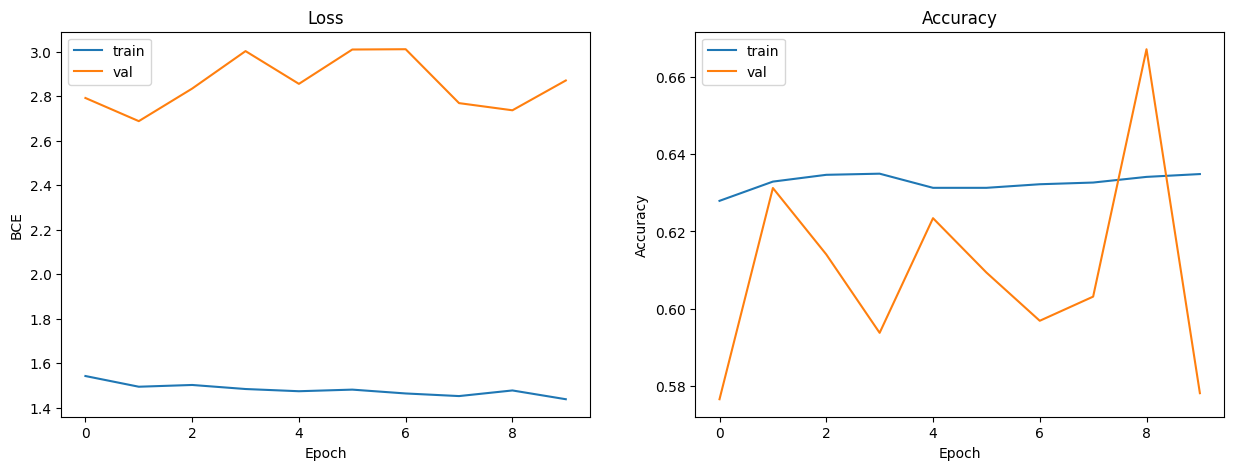

In [46]:
loss = np.stack((vgg_16_lora_results.history["loss"], vgg_16_lora_results.history["val_loss"]))
accuracy = np.stack((vgg_16_lora_results.history["accuracy"], vgg_16_lora_results.history["val_accuracy"]))

plot_loss_accuracy(loss.T, accuracy.T, ["train", "val"])

Plotting the confusion matrix, we again see that we are good at predicting **no planes**, but not so good at predicting **planes**.

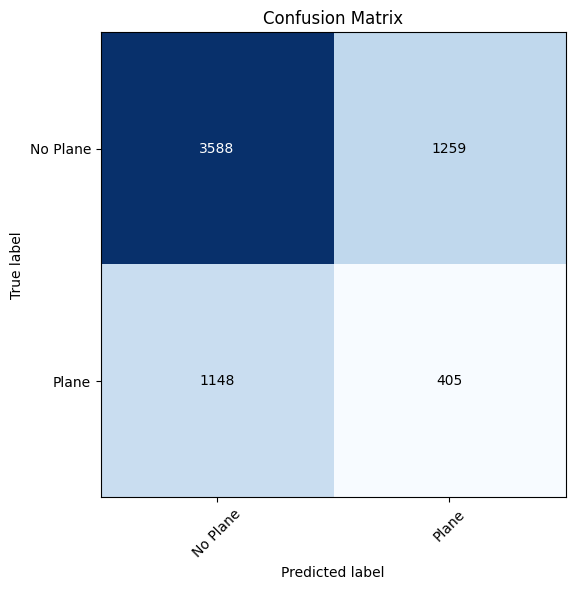

In [47]:
plot_confusion_matrix(vgg16_lora, planes_test, ["No Plane", "Plane"])

### Exercise 2: Interpreting the results (5 points)

**This exercise is required only for students that have not submitted the first homework, or for students who want to raise their mid-term mark (mark <= 8/10). For a mark of 8/10 or higher, an additional point can also be recovered during the exam.**

> **To recap**: if you submitted the mid-term homework, implement only Exercise 1, for a total of *10 points*. If you did not submit the mid-term homework, implement Exercises 1 and 2 for a total of *15 points*.

[LIME](https://arxiv.org/abs/1602.04938) (**Local Interpretable Model-agnostic Explanations**) is a very common explainability method, which trains a small interpretable model (e.g., a linear model) around a prediction $f(x)$ to interpret the prediction. For this exercise:

1. Read carefully the original LIME paper.
2. Re-implement the LIME algorithm and test it on 1 or 2 predictions given by your neural network (from Exercise 1).
3. This must be done fully in TensorFlow (same as the previous exercise).
4. LIME requires to select how to represent the inputs (e.g., patches of the original image). Explain your choice below.
5. Analyze the results you obtain.

In [ ]:
# TODO: Implement and test LIME.

### Final checklist

1. Carefully check all textual descriptions and the code. Insert comments when needed. <ins>Check for TODO to see if you missed anything.</ins>
2. Run everything one final time. *Please do not send me notebooks with errors or cells that are not working.*
3. Send the completed notebook following the instructions on top.

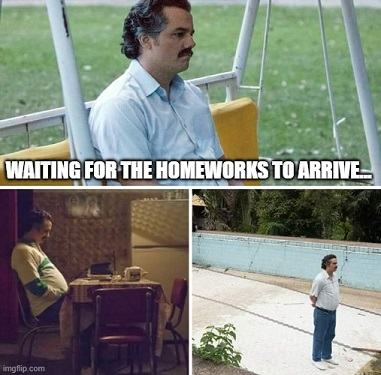